<a href="https://colab.research.google.com/github/shravani-04/BIAS-DETECTION/blob/main/Bias_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample data.csv")

print(df.head())

df.dropna(subset=['text'], inplace=True)
print(f"Dataset size after removing nulls: {df.shape}")


                                                text
0  Swiss voters will head to the polls to decide ...
1  Unbelievably, with all they had seen their chi...
2  And while states like Massachusetts�among othe...
3  Oxford chose "climate emergency" as the word o...
4  This, of course, was before the president igno...
Dataset size after removing nulls: (178, 1)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)
print(df[['text', 'cleaned_text']].head())


                                                text  \
0  Swiss voters will head to the polls to decide ...   
1  Unbelievably, with all they had seen their chi...   
2  And while states like Massachusetts�among othe...   
3  Oxford chose "climate emergency" as the word o...   
4  This, of course, was before the president igno...   

                                        cleaned_text  
0  swiss voters head polls decide whether homopho...  
1  unbelievably seen child suffer parents refused...  
2  states like massachusettsamong othersautomatic...  
3  oxford chose climate emergency word year short...  
4  course president ignored national security tea...  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_text'])

print("TF-IDF Matrix Shape:", X.shape)


TF-IDF Matrix Shape: (178, 5000)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

df['cluster'] = kmeans.labels_
print(df.head(10))

                                                text  \
0  Swiss voters will head to the polls to decide ...   
1  Unbelievably, with all they had seen their chi...   
2  And while states like Massachusetts�among othe...   
3  Oxford chose "climate emergency" as the word o...   
4  This, of course, was before the president igno...   
5  Polling for the Democratic nomination tells a ...   
6  In another clip, the group can be seen scrambl...   
7  Across the United States, legislators are atte...   
8  Donald Trump appeared to make some important n...   
9  Proponents of stricter protections for student...   

                                        cleaned_text  cluster  
0  swiss voters head polls decide whether homopho...        1  
1  unbelievably seen child suffer parents refused...        1  
2  states like massachusettsamong othersautomatic...        1  
3  oxford chose climate emergency word year short...        1  
4  course president ignored national security tea...        0  

In [ ]:
cluster_0_texts = df[df['cluster'] == 0]['text']
cluster_1_texts = df[df['cluster'] == 1]['text']

print("Cluster 0 (Bias Category 0):")
print(cluster_0_texts.head(), "\n")

print("Cluster 1 (unbiased category):")
print(cluster_1_texts.head())

Cluster 0 (Bias Category 0):
4     This, of course, was before the president igno...
5     Polling for the Democratic nomination tells a ...
22    his is another example of Trump�s false dichot...
29    Some people have expressed concern that full c...
38    Rep. Al Green (D-TX) at a hearing on Wednesday...
Name: text, dtype: object 

Cluster 1 (unbiased category):
0    Swiss voters will head to the polls to decide ...
1    Unbelievably, with all they had seen their chi...
2    And while states like Massachusetts�among othe...
3    Oxford chose "climate emergency" as the word o...
6    In another clip, the group can be seen scrambl...
Name: text, dtype: object


In [ ]:
df['label'] = df['cluster'].map({0: 1, 1: 0})  # 1 = biased, 0 = non-biased

print(df[['text', 'cluster', 'label']].head())

                                                text  cluster  label
0  Swiss voters will head to the polls to decide ...        1      0
1  Unbelievably, with all they had seen their chi...        1      0
2  And while states like Massachusetts�among othe...        1      0
3  Oxford chose "climate emergency" as the word o...        1      0
4  This, of course, was before the president igno...        0      1


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")


Training set size: (142, 5000), Testing set size: (36, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Calculate and print accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        29
           1       0.00      0.00      0.00         7

    accuracy                           0.81        36
   macro avg       0.40      0.50      0.45        36
weighted avg       0.65      0.81      0.72        36



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


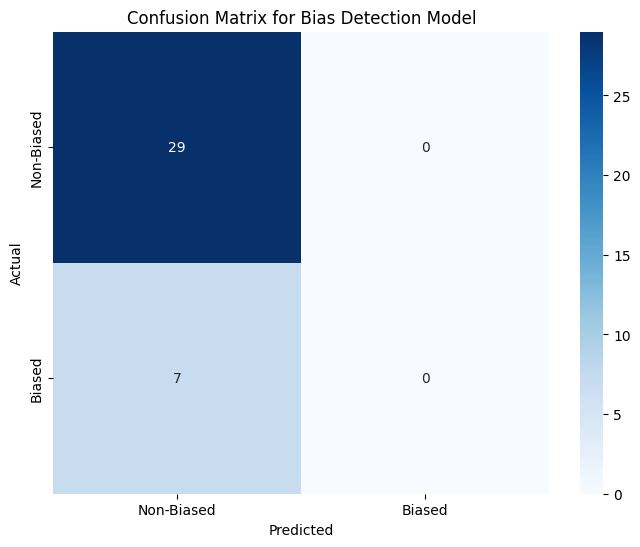

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Biased', 'Biased'], yticklabels=['Non-Biased', 'Biased'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Bias Detection Model')
plt.show()


In [ ]:
def mitigate_bias(text, biased_terms):

    # Define a mapping of biased terms to neutral alternatives
    term_replacement = {
        'inferior': 'less capable',
        'weak': 'less strong',
        'less capable': 'equally capable',
        # Add more mappings here as needed
    }

    # Replace biased terms with neutral ones
    for term in biased_terms:
        if term in term_replacement:
            text = text.replace(term, term_replacement[term])

    return text


In [ ]:
# Example biased terms to mitigate
biased_terms_list = ["inferior", "weak", "less capable"]

# Test sentence
biased_sentence = "Women are less capable leaders."

# Mitigate the biased sentence
mitigated_sentence = mitigate_bias(biased_sentence, biased_terms_list)
print("Mitigated Sentence:", mitigated_sentence)

Mitigated Sentence: Women are equally capable leaders.


In [ ]:
pip install datasets==3.1.0 fsspec==2024.6.1 gcsfs==2024.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: gcsfs
    Found existing installation: gcsfs 2024.10.0
    Uninstalling gcsfs-2024.10.0:
      Successfully uninstalled gcsfs-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_m

In [ ]:
import pandas as pd

# Remove any rows with null values
df = df.dropna()

# Print the dataset size after removing nulls
print(f"Dataset size after removing nulls: {df.shape}")
from transformers import AutoTokenizer

# Load a pre-trained tokenizer (e.g., BERT tokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the text column
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_df = df['text'].apply(lambda x: tokenizer(x, padding="max_length", truncation=True, max_length=128))

# Convert the tokenized data into a list of tokenized dictionaries
tokenized_data = list(tokenized_df)

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(tokenized_data, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")


Dataset size after removing nulls: (178, 4)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training data size: 142
Validation data size: 36


In [ ]:
print(type(train_data))
print(train_data[:2])  # Check the first 2 entries

print(type(val_data))
print(val_data[:2])  # Check the first 2 entries

<class 'list'>
[{'input_ids': [101, 2047, 4277, 1999, 3448, 10580, 2008, 2110, 2375, 12088, 2064, 8116, 12720, 3282, 2491, 5761, 2130, 1999, 1037, 2110, 2073, 1037, 5554, 1010, 2092, 1011, 4114, 4559, 2003, 9205, 2055, 8650, 2049, 4409, 1998, 7098, 1997, 2049, 5933, 4535, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Assuming the 'text' column and 'label' column exist in the DataFrame (replace 'label' if your column name is different)
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Load a pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data (converting text to token ids)
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Tokenize the dataset
train_encodings = tokenizer(train_data['text'].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_data['text'].tolist(), truncation=True, padding=True, max_length=128)

# Convert labels to tensors
train_labels = torch.tensor(train_data['label'].tolist())  # Replace with your actual labels
val_labels = torch.tensor(val_data['label'].tolist())      # Replace with your actual labels

# Create Dataset Class
class BiasDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch Datasets
train_dataset = BiasDetectionDataset(train_encodings, train_labels)
val_dataset = BiasDetectionDataset(val_encodings, val_labels)

# Load model for sequence classification (fine-tuning)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model predictions and checkpoints
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    report_to="none"                 # Disable W&B integration
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to be trained
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,            # Validation dataset
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.635500
20,0.624100
30,0.590800
40,0.568800
50,0.510000


TrainOutput(global_step=54, training_loss=0.5755010423836885, metrics={'train_runtime': 582.4932, 'train_samples_per_second': 0.731, 'train_steps_per_second': 0.093, 'total_flos': 24956494711920.0, 'train_loss': 0.5755010423836885, 'epoch': 3.0})

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate()

print("Evaluation result:", eval_result)


Evaluation result: {'eval_loss': 0.5077448487281799, 'eval_runtime': 11.1199, 'eval_samples_per_second': 3.237, 'eval_steps_per_second': 0.27, 'epoch': 3.0}


In [ ]:
# Sample prediction
sample_text = "Your example text for classification."
inputs = tokenizer(sample_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
model.eval()
with torch.no_grad():
    logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=-1)
    print(f"Predicted class: {predicted_class.item()}")


Predicted class: 0


In [ ]:
"""from sklearn.metrics import accuracy_score

# Ensure that val_labels and val_preds are on the CPU
val_labels = val_labels.cpu()  # If val_labels is a tensor, move it to CPU

# Generate predictions for the validation set
val_preds = []
for text in val_texts:  # Assuming val_texts is your validation data
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    val_preds.append(predicted_class)

# Convert predictions to a list (if they are tensors)
val_preds = torch.tensor(val_preds).cpu()  # Ensure predictions are also on CPU

# Evaluate accuracy
accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {accuracy}")
"""

from sklearn.metrics import accuracy_score
import torch

# Assuming you have your validation data in 'val_data' as created earlier
# Ensure that val_labels and val_preds are on the CPU
val_labels = val_data['label'].tolist() # Extract the labels

val_texts = val_data['text'].tolist()  # Extract the texts
val_labels = torch.tensor(val_labels)
# Generate predictions for the validation set
val_preds = []
for text in val_texts:
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    val_preds.append(predicted_class)

# Convert predictions to a list (if they are tensors)
val_preds = torch.tensor(val_preds)  # Ensure predictions are also on CPU

# Evaluate accuracy
accuracy = accuracy_score(val_labels.cpu(), val_preds.cpu())
print(f"Validation Accuracy: {accuracy}")


Validation Accuracy: 0.8055555555555556


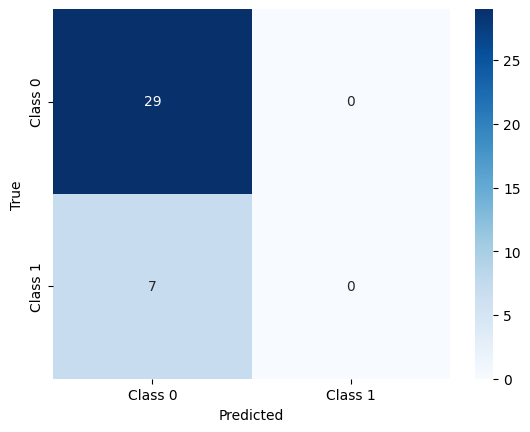

              precision    recall  f1-score   support

           0       0.81      1.00      0.89        29
           1       0.00      0.00      0.00         7

    accuracy                           0.81        36
   macro avg       0.40      0.50      0.45        36
weighted avg       0.65      0.81      0.72        36



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(classification_report(val_labels, val_preds))

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model for text generation (can be replaced with any text generation model)
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

def mitigate_bias_with_generation(biased_text):
    # Preprocess the text for T5
    input_text = f"rewrite this sentence to be neutral: {biased_text}"
    inputs = t5_tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Generate the neutral text
    with torch.no_grad():
        outputs = t5_model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)

    # Decode the generated text
    neutral_text = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return neutral_text

# Example biased text
biased_text = "Women are naturally weaker than men."

# Apply bias mitigation
neutral_text = mitigate_bias_with_generation(biased_text)
print(f"Original Text: {biased_text}")
print(f"Neutralized Text: {neutral_text}")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Original Text: Women are naturally weaker than men.
Neutralized Text: rewrite this sentence to be neutral: Women are naturally weaker than men.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

bias_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
bias_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def detect_bias(text, threshold=0.6):
  inputs = bias_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
  bias_model.eval()
  with torch.no_grad():
    logits = bias_model(**inputs).logits
    predicted_probability = torch.sigmoid(logits[:, 1]).item()  # Probability of class 1 (biased)
    predicted_class = 1 if predicted_probability >= threshold else 0
  return predicted_class

!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
    pos_tags = [token.pos_ for token in doc if not token.is_stop and not token.is_punct]
    # Incorporate POS tags for bias detection features
    return " ".join(tokens)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install gradio


  Using cached gradio-5.25.0-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached fastapi-0.115.12-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.5.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached gradio_client-1.8.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.20-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.11.5-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.46.2-py3-none-any.whl.metadata (6.2 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached uvicorn-0.34.1-py3-none-any.whl.metadata (6.5 kB)
Using cached gradio-5.25.0-py

In [ ]:
# Install necessary packages
!pip install gradio transformers torch spacy pillow numpy
!python -m spacy download en_core_web_sm

import gradio as gr
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import spacy
import time
import numpy as np
import random
from PIL import Image

# Load spaCy for text preprocessing
nlp = spacy.load("en_core_web_sm")

# Define bias categories and terms
bias_categories = {
    "racial": {
        "name": "Racial/Ethnic Bias",
        "description": "Language that perpetuates stereotypes or discrimination based on race or ethnicity",
        "examples": ["immigrants", "illegal", "terrorist", "minority", "urban"]
    },
    "gender": {
        "name": "Gender Bias",
        "description": "Language that reinforces gender stereotypes or discriminates based on gender",
        "examples": ["emotional", "bossy", "hysterical", "man up", "like a girl"]
    },
    "socioeconomic": {
        "name": "Socioeconomic Bias",
        "description": "Language that shows prejudice based on economic or social status",
        "examples": ["welfare", "poor", "homeless", "unemployed", "ghetto"]
    },
    "disability": {
        "name": "Disability Bias",
        "description": "Language that marginalizes or stereotypes people with disabilities",
        "examples": ["handicapped", "disabled", "special needs", "retarded", "crazy"]
    },
    "age": {
        "name": "Age Bias",
        "description": "Language that discriminates against people based on their age",
        "examples": ["elderly", "boomer", "millennial", "senior", "old"]
    }
}

# Flatten the list of biased terms for detection
biased_terms = []
for category in bias_categories.values():
    biased_terms.extend(category["examples"])

# Define contextual replacements for different biased terms
replacements = {
    # Racial/Ethnic bias terms
    'immigrants': 'newcomers',
    'illegal': 'undocumented',
    'terrorist': 'extremist',
    'minority': 'underrepresented group',
    'urban': 'city',

    # Gender bias terms
    'emotional': 'passionate',
    'bossy': 'assertive',
    'hysterical': 'upset',
    'like a girl': 'ineffectively',
    'man up': 'be brave',

    # Socioeconomic bias terms
    'welfare': 'social assistance',
    'poor': 'economically disadvantaged',
    'homeless': 'unhoused',
    'unemployed': 'between jobs',
    'ghetto': 'underserved neighborhood',

    # Disability bias terms
    'handicapped': 'person with a disability',
    'disabled': 'person with a disability',
    'special needs': 'specific needs',
    'retarded': 'developmentally delayed',
    'crazy': 'concerning',

    # Age bias terms
    'elderly': 'older adult',
    'boomer': 'baby boomer generation',
    'old': 'mature',
    'senior': 'older adult'
}

# Load models (show progress) - FIXED VERSION
print("Loading text generation model for bias mitigation...")

# Option 1: Try with different model that has no TF vs PT conflict
try:
    # This model is known to work well with the default pipeline setup
    text_model = pipeline("text2text-generation", model="t5-small", max_length=512)
    print("Text model loaded successfully!")
except Exception as e:
    print(f"Failed to load t5-small: {e}")
    # Option 2: Skip model and use rule-based approach only
    print("Falling back to rule-based text processing only.")
    text_model = None

# === TEXT ANALYSIS FUNCTIONS ===

# Text bias detection function
def detect_text_bias(text):
    start_time = time.time()

    if not text.strip():
        return {
            "biasDetected": False,
            "biasLevel": "none",
            "biasTerms": [],
            "biasCategories": [],
            "originalContent": text,
            "timestamp": time.time(),
            "contentType": "text",
            "processingTime": 0
        }

    text_lower = text.lower()
    found_terms = []

    # Find biased terms in the text
    for term in biased_terms:
        # Simple word boundary check
        if f" {term} " in f" {text_lower} " or text_lower.startswith(f"{term} ") or text_lower.endswith(f" {term}"):
            found_terms.append(term)

    # Identify which categories the biased terms belong to
    categories = set()
    for term in found_terms:
        for category_key, category in bias_categories.items():
            if term in category["examples"]:
                categories.add(category["name"])

    # Determine bias level based on number of terms and categories
    bias_level = "none"
    if found_terms:
        if len(found_terms) >= 3 or len(categories) >= 2:
            bias_level = "high"
        elif len(found_terms) >= 2:
            bias_level = "medium"
        else:
            bias_level = "low"

    # Mitigate biased text
    mitigated_content = text
    if found_terms:
        # Replace biased terms with more neutral ones
        for biased_term, replacement in replacements.items():
            if biased_term in found_terms:
                # Replace with word boundaries to avoid partial replacements
                pattern = f" {biased_term} "
                if f" {text_lower} ".find(pattern) != -1:
                    mitigated_content = mitigated_content.replace(biased_term, replacement)
                elif text_lower.startswith(f"{biased_term} "):
                    mitigated_content = replacement + mitigated_content[len(biased_term):]
                elif text_lower.endswith(f" {biased_term}"):
                    mitigated_content = mitigated_content[:-len(biased_term)] + replacement

        # For sentences with complex bias, use the text model for better paraphrasing
        if bias_level in ["medium", "high"] and text_model is not None:
            try:
                prompt = f"Rewrite this text to remove bias while preserving meaning: {text}"
                model_output = text_model(prompt)[0]["generated_text"]
                if model_output and len(model_output.strip()) > 0:
                    mitigated_content = model_output
            except Exception as e:
                print(f"Error using text model: {e}")
                # Continue with the basic replacement if model fails

    end_time = time.time()

    return {
        "biasDetected": bool(found_terms),
        "biasLevel": bias_level,
        "biasTerms": found_terms,
        "biasCategories": list(categories),
        "mitigatedContent": mitigated_content if found_terms else None,
        "originalContent": text,
        "timestamp": time.time(),
        "contentType": "text",
        "processingTime": (end_time - start_time) * 1000  # in milliseconds
    }

# === IMAGE ANALYSIS FUNCTIONS ===

# Mock image analysis function (similar to the current implementation)
def analyze_image_bias(image):
    # Simulate API processing time
    time.sleep(1.5)

    # Generate some random values for representation demonstration
    representation_counts = {
        "male": random.randint(0, 10),
        "female": random.randint(0, 10),
        "nonBinary": random.randint(0, 3),
        "white": random.randint(0, 10),
        "black": random.randint(0, 5),
        "asian": random.randint(0, 5),
        "hispanic": random.randint(0, 5),
        "other": random.randint(0, 3)
    }

    # Calculate percentages
    total_people = sum([representation_counts["male"], representation_counts["female"], representation_counts["nonBinary"]])
    if total_people == 0:  # Avoid division by zero
        total_people = 1

    male_percentage = representation_counts["male"] / total_people
    female_percentage = representation_counts["female"] / total_people
    white_percentage = representation_counts["white"] / total_people

    # Detect bias based on representation
    bias_detected = False
    bias_level = "none"
    bias_description = "No significant bias detected in this image."

    # Detect gender representation bias
    if male_percentage > 0.8 or female_percentage > 0.8:
        bias_detected = True
        bias_level = "high"
        bias_description = f"This image shows significantly {'male' if male_percentage > 0.8 else 'female'} dominated representation ({round((male_percentage if male_percentage > 0.8 else female_percentage) * 100)}%)."
    elif male_percentage > 0.7 or female_percentage > 0.7:
        bias_detected = True
        bias_level = "medium"
        bias_description = f"This image shows {'male' if male_percentage > 0.7 else 'female'} dominated representation ({round((male_percentage if male_percentage > 0.7 else female_percentage) * 100)}%)."
    elif male_percentage > 0.6 or female_percentage > 0.6:
        bias_detected = True
        bias_level = "low"
        bias_description = f"This image shows slightly {'male' if male_percentage > 0.6 else 'female'} dominated representation ({round((male_percentage if male_percentage > 0.6 else female_percentage) * 100)}%)."

    # Detect racial representation bias
    if white_percentage > 0.8:
        bias_detected = True
        bias_level = "high" if bias_level == "high" else "medium"
        bias_description += f" It also shows predominantly white representation ({round(white_percentage * 100)}%)."
    elif white_percentage > 0.7:
        bias_detected = True
        bias_level = "low" if bias_level == "none" else bias_level
        bias_description += f" It also shows mostly white representation ({round(white_percentage * 100)}%)."

    return {
        "representationCounts": representation_counts,
        "biasDetected": bias_detected,
        "biasLevel": bias_level,
        "biasDescription": bias_description
    }

# Convert image analysis result to standard format
def format_image_analysis(result, image_url):
    return {
        "biasDetected": result["biasDetected"],
        "biasLevel": result["biasLevel"],
        "biasTerms": [],
        "biasCategories": ["Representation Bias"] if result["biasDetected"] else [],
        "originalContent": image_url,
        "mitigatedContent": "Consider using images with more diverse representation across gender, ethnicity, and other demographic categories." if result["biasDetected"] else None,
        "timestamp": time.time(),
        "contentType": "image",
        "processingTime": 1500,  # mock processing time
        "representationCounts": result["representationCounts"],
        "biasDescription": result["biasDescription"]
    }

# === UI FUNCTIONS ===

# Text analysis handler for UI
def analyze_text_ui(text):
    if not text.strip():
        return "Please enter some text to analyze."

    # Perform analysis
    result = detect_text_bias(text)

    # Format output for Gradio
    output = f"""
    <div class="result-container">
    <h1 class="analysis-title">Bias Analysis Results</h1>

    <div class="summary-section">
    <h2>Analysis Summary</h2>
    <div class="summary-item"><span class="label">Bias Detected:</span> <span class="value bias-{result["biasLevel"]}">{"Yes" if result["biasDetected"] else "No"}</span></div>
    <div class="summary-item"><span class="label">Bias Level:</span> <span class="value bias-{result["biasLevel"]}">{result["biasLevel"].capitalize()}</span></div>
    <div class="summary-item"><span class="label">Processing Time:</span> <span class="value">{result["processingTime"]:.2f}ms</span></div>
    </div>

    <div class="original-text">
    <h2>Original Text</h2>
    <p>{result["originalContent"]}</p>
    </div>
    """

    if result["biasDetected"]:
        terms_html = ", ".join([f'<span class="bias-term">{term}</span>' for term in result["biasTerms"]])
        categories_html = ", ".join([f'<span class="bias-category">{category}</span>' for category in result["biasCategories"]])

        output += f"""
        <div class="issues-section">
        <h2>Detected Issues</h2>
        <div class="issue-item">
            <span class="label">Biased Terms Found:</span>
            <div class="terms-list">{terms_html}</div>
        </div>

        <div class="issue-item">
            <span class="label">Bias Categories:</span>
            <div class="categories-list">{categories_html}</div>
        </div>
        </div>

        <div class="alternative-section bias-{result["biasLevel"]}">
        <h2>Suggested Alternative</h2>
        <p>{result["mitigatedContent"]}</p>
        </div>
        """
    else:
        output += """
        <div class="no-bias-section">
        <h2>Analysis Details</h2>
        <p>No bias detected in the provided text. The content appears to be neutral and free from common biased language patterns.</p>
        </div>
        """

    output += "</div>"  # Close result-container
    return output

# Image analysis handler for UI
def analyze_image_ui(image):
    if image is None:
        return "Please upload an image to analyze."

    # Convert to URL for saving
    image_path = "temp_image.jpg"
    image.save(image_path)

    # Analyze image
    result = analyze_image_bias(image)
    formatted_result = format_image_analysis(result, image_path)

    # Gender representation percentages
    total_gender = sum([
        formatted_result["representationCounts"]["male"],
        formatted_result["representationCounts"]["female"],
        formatted_result["representationCounts"]["nonBinary"]
    ])
    if total_gender == 0:  # Avoid division by zero
        total_gender = 1

    male_pct = formatted_result["representationCounts"]["male"] / total_gender * 100
    female_pct = formatted_result["representationCounts"]["female"] / total_gender * 100
    nonbinary_pct = formatted_result["representationCounts"]["nonBinary"] / total_gender * 100

    # Ethnicity representation percentages
    total_ethnicity = sum([
        formatted_result["representationCounts"]["white"],
        formatted_result["representationCounts"]["black"],
        formatted_result["representationCounts"]["asian"],
        formatted_result["representationCounts"]["hispanic"],
        formatted_result["representationCounts"]["other"]
    ])
    if total_ethnicity == 0:  # Avoid division by zero
        total_ethnicity = 1

    white_pct = formatted_result["representationCounts"]["white"] / total_ethnicity * 100
    black_pct = formatted_result["representationCounts"]["black"] / total_ethnicity * 100
    asian_pct = formatted_result["representationCounts"]["asian"] / total_ethnicity * 100
    hispanic_pct = formatted_result["representationCounts"]["hispanic"] / total_ethnicity * 100
    other_pct = formatted_result["representationCounts"]["other"] / total_ethnicity * 100

    # Format output with enhanced HTML/CSS for Gradio
    output = f"""
    <div class="result-container">
    <h1 class="analysis-title">Image Analysis Results</h1>

    <div class="summary-section">
    <h2>Analysis Summary</h2>
    <div class="summary-item"><span class="label">Bias Detected:</span> <span class="value bias-{formatted_result["biasLevel"]}">{"Yes" if formatted_result["biasDetected"] else "No"}</span></div>
    <div class="summary-item"><span class="label">Bias Level:</span> <span class="value bias-{formatted_result["biasLevel"]}">{formatted_result["biasLevel"].capitalize()}</span></div>
    </div>

    <div class="bias-description">
    <h2>Bias Description</h2>
    <p>{formatted_result["biasDescription"]}</p>
    </div>

    <div class="stats-section">
    <h2>Representation Statistics</h2>

    <div class="stats-container">
        <div class="stats-column">
            <h3>Gender Representation</h3>
            <div class="stat-item">
                <div class="stat-label">Male: {formatted_result["representationCounts"]["male"]} ({male_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill male" style="width: {male_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Female: {formatted_result["representationCounts"]["female"]} ({female_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill female" style="width: {female_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Non-Binary: {formatted_result["representationCounts"]["nonBinary"]} ({nonbinary_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill nonbinary" style="width: {nonbinary_pct}%;"></div>
                </div>
            </div>
        </div>

        <div class="stats-column">
            <h3>Ethnic Representation</h3>
            <div class="stat-item">
                <div class="stat-label">White: {formatted_result["representationCounts"]["white"]} ({white_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill white" style="width: {white_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Black: {formatted_result["representationCounts"]["black"]} ({black_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill black" style="width: {black_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Asian: {formatted_result["representationCounts"]["asian"]} ({asian_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill asian" style="width: {asian_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Hispanic: {formatted_result["representationCounts"]["hispanic"]} ({hispanic_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill hispanic" style="width: {hispanic_pct}%;"></div>
                </div>
            </div>
            <div class="stat-item">
                <div class="stat-label">Other: {formatted_result["representationCounts"]["other"]} ({other_pct:.1f}%)</div>
                <div class="progress-bar">
                    <div class="progress-fill other" style="width: {other_pct}%;"></div>
                </div>
            </div>
        </div>
    </div>
    </div>
    """

    if formatted_result["biasDetected"]:
        output += f"""
        <div class="recommendations bias-{formatted_result["biasLevel"]}">
        <h2>Recommendations</h2>
        <p>{formatted_result["mitigatedContent"]}</p>
        <p>Consider more balanced representation across different demographics for more inclusive imagery.</p>
        </div>
        """

    output += "</div>"  # Close result-container
    return output

# Custom CSS for a colorful, modern interface
css = """
:root {
    --primary: #9b87f5;
    --primary-light: #E5DEFF;
    --primary-dark: #7E69AB;
    --secondary: #D946EF;
    --accent: #33C3F0;
    --neutral: #F1F0FB;
    --success: #4BB543;
    --warning: #FFB347;
    --danger: #FF5733;
    --text-dark: #2D2A3C;
    --text-light: #F5F3FF;
    --card-bg: rgba(255, 255, 255, 0.9);
    --shadow: 0 8px 30px rgba(0,0,0,0.12);
}

body {
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    background: linear-gradient(135deg, var(--primary-light), var(--neutral));
    color: var(--text-dark);
    line-height: 1.6;
}

/* Containers */
.gradio-container {
    max-width: 1200px !important;
    margin: 0 auto !important;
}

.result-container {
    background: var(--card-bg);
    border-radius: 16px;
    box-shadow: var(--shadow);
    padding: 20px;
    margin-top: 20px;
    border: 1px solid var(--primary-light);
    animation: fadeIn 0.5s ease-out;
}

@keyframes fadeIn {
    from { opacity: 0; transform: translateY(10px); }
    to { opacity: 1; transform: translateY(0); }
}

/* Typography */
.analysis-title {
    color: var(--primary-dark);
    font-size: 28px;
    font-weight: 700;
    text-align: center;
    margin-bottom: 24px;
    background: linear-gradient(to right, var(--primary), var(--secondary));
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    padding: 10px 0;
}

h2 {
    color: var(--primary-dark);
    font-size: 22px;
    font-weight: 600;
    margin-top: 24px;
    margin-bottom: 16px;
    border-bottom: 2px solid var(--primary-light);
    padding-bottom: 8px;
}

h3 {
    color: var(--text-dark);
    font-size: 18px;
    font-weight: 600;
    margin-bottom: 12px;
}

/* Sections */
.summary-section, .original-text, .issues-section, .alternative-section, .no-bias-section, .bias-description, .stats-section, .recommendations {
    margin-bottom: 24px;
    padding: 16px;
    border-radius: 12px;
    background: rgba(255, 255, 255, 0.5);
    backdrop-filter: blur(10px);
    border: 1px solid rgba(155, 135, 245, 0.2);
}

/* Summary items */
.summary-item {
    display: flex;
    align-items: center;
    margin-bottom: 8px;
}

.label {
    font-weight: 600;
    min-width: 150px;
    color: var(--text-dark);
}

.value {
    font-weight: 500;
}

.bias-term, .bias-category {
    display: inline-block;
    padding: 4px 12px;
    margin: 4px;
    border-radius: 20px;
    font-size: 14px;
    font-weight: 500;
}

.bias-term {
    background-color: rgba(217, 70, 239, 0.2);
    color: var(--secondary);
    border: 1px solid rgba(217, 70, 239, 0.3);
}

.bias-category {
    background-color: rgba(155, 135, 245, 0.2);
    color: var(--primary-dark);
    border: 1px solid rgba(155, 135, 245, 0.3);
}

/* Bias levels */
.bias-none {
    color: var(--success);
}

.bias-low {
    color: var(--accent);
}

.bias-medium {
    color: var(--warning);
}

.bias-high {
    color: var(--danger);
}

.alternative-section, .recommendations {
    border-left: 4px solid;
}

.alternative-section.bias-low, .recommendations.bias-low {
    border-left-color: var(--accent);
    background-color: rgba(51, 195, 240, 0.1);
}

.alternative-section.bias-medium, .recommendations.bias-medium {
    border-left-color: var(--warning);
    background-color: rgba(255, 179, 71, 0.1);
}

.alternative-section.bias-high, .recommendations.bias-high {
    border-left-color: var(--danger);
    background-color: rgba(255, 87, 51, 0.1);
}

/* Stats visualization */
.stats-container {
    display: flex;
    flex-wrap: wrap;
    gap: 20px;
}

.stats-column {
    flex: 1;
    min-width: 280px;
}

.stat-item {
    margin-bottom: 12px;
}

.stat-label {
    font-size: 14px;
    margin-bottom: 4px;
    display: flex;
    justify-content: space-between;
}

.progress-bar {
    height: 8px;
    background-color: rgba(0,0,0,0.05);
    border-radius: 4px;
    overflow: hidden;
}

.progress-fill {
    height: 100%;
    border-radius: 4px;
    transition: width 1s ease-out;
}

/* Progress bar colors */
.progress-fill.male {
    background: linear-gradient(to right, #3498db, #2980b9);
}

.progress-fill.female {
    background: linear-gradient(to right, #D946EF, #9b59b6);
}

.progress-fill.nonbinary {
    background: linear-gradient(to right, #9b87f5, #8e44ad);
}

.progress-fill.white {
    background: linear-gradient(to right, #ecf0f1, #bdc3c7);
}

.progress-fill.black {
    background: linear-gradient(to right, #34495e, #2c3e50);
}

.progress-fill.asian {
    background: linear-gradient(to right, #f1c40f, #f39c12);
}

.progress-fill.hispanic {
    background: linear-gradient(to right, #e74c3c, #c0392b);
}

.progress-fill.other {
    background: linear-gradient(to right, #1abc9c, #16a085);
}

/* Button styling */
button.primary {
    background: linear-gradient(to right, var(--primary), var(--primary-dark)) !important;
    border: none !important;
    color: white !important;
    border-radius: 8px !important;
    transition: all 0.3s ease !important;
    font-weight: 600 !important;
    padding: 12px 24px !important;
    box-shadow: 0 4px 15px rgba(155, 135, 245, 0.4) !important;
}

button.primary:hover {
    transform: translateY(-2px);
    box-shadow: 0 8px 20px rgba(155, 135, 245, 0.6) !important;
}

/* Tabs */
.tabs {
    margin-bottom: 24px !important;
}

/* Media queries */
@media (max-width: 768px) {
    .stats-container {
        flex-direction: column;
    }
}

/* Animated gradients */
.app-header {
    background: linear-gradient(-45deg, #9b87f5, #D946EF, #33C3F0, #7E69AB);
    background-size: 400% 400%;
    animation: gradient 15s ease infinite;
    border-radius: 16px;
    padding: 40px 20px;
    text-align: center;
    margin-bottom: 30px;
    box-shadow: var(--shadow);
}

@keyframes gradient {
    0% {
        background-position: 0% 50%;
    }
    50% {
        background-position: 100% 50%;
    }
    100% {
        background-position: 0% 50%;
    }
}
"""

# Create Gradio interface with enhanced UI - FIXED INDENTATION
with gr.Blocks(css=css, theme=gr.themes.Soft()) as demo:
    with gr.Column():
        # Animated header with gradient background
        with gr.Row(elem_classes="app-header"):
            gr.Markdown("""
            # ✨ BIAS BUSTERS ✨
            ### Detects and mitigates bias in text and images

            This tool helps identify potential bias in your content and suggests more inclusive alternatives.
            """)

        # Main Tabs
        with gr.Tabs(elem_classes="tabs"):
            # Text Analysis Tab
            with gr.Tab("Text Analysis 📝"):
                with gr.Column():
                    gr.Markdown("""
                    ### Analyze text for potential bias

                    Enter or paste text below to scan it for potential biased language.
                    The tool will identify biased terms and suggest more inclusive alternatives.
                    """)

                    text_input = gr.Textbox(
                        label="Enter text to analyze",
                        placeholder="Type or paste text here to analyze for potential bias...",
                        lines=6
                    )
                    analyze_text_button = gr.Button("Analyze Text for Bias", elem_classes="primary")

                    # Example biased texts with colorful styling
                    with gr.Accordion("Example Potentially Biased Texts", open=False):
                        gr.Examples(
                            examples=[
                                "Immigrants often bring crime and drugs into our communities.",
                                "Women are too emotional to handle leadership positions effectively.",
                                "The elderly cannot understand modern technology.",
                                "Homeless people are lazy and don't want to work.",
                                "She's pretty smart for a girl.",
                                "He's a credit to his race."
                            ],
                            inputs=text_input,
                        )

                    text_output = gr.HTML(elem_classes="analysis-panel")

                    analyze_text_button.click(
                        fn=analyze_text_ui,
                        inputs=text_input,
                        outputs=text_output
                    )

            # Image Analysis Tab
            with gr.Tab("Image Analysis 🖼️"):
                with gr.Column():
                    gr.Markdown("""
                    ### Analyze images for representation bias

                    Upload an image to analyze it for potential representation bias across gender and ethnic groups.
                    This tool works best with images containing multiple people.
                    """)

                    image_input = gr.Image(type="pil", label="Upload Image")
                    analyze_image_button = gr.Button("Analyze Image for Bias", elem_classes="primary")

                    image_output = gr.HTML(elem_classes="analysis-panel")

                    analyze_image_button.click(
                        fn=analyze_image_ui,
                        inputs=image_input,
                        outputs=image_output
                    )

        # Footer with fancy gradient
        with gr.Row():
            gr.Markdown("""
            <div style="text-align: center; margin-top: 40px; padding: 20px; border-radius: 12px; background: linear-gradient(to right, rgba(155, 135, 245, 0.2), rgba(217, 70, 239, 0.2));">
                <p style="color: #7E69AB; font-weight: 500;">BIAS BUSTERS © 2025 </p>
                <p style="font-size: 12px; color: #9b87f5;">Built with Gradio, Transformers, and spaCy</p>
            </div>
            """)

# Launch the app with Gradio's built-in sharing feature
demo.launch(share=True)


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cpu


Text model loaded successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://35cfeb3f6b219fae83.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
